# Задача классификации: превышает ли значение IC50 медианное значение выборки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,  FunctionTransformer
from sklearn.pipeline import Pipeline

from catboost import  Pool
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 62025


In [2]:
# Прочитаем обработанный датасет
df = pd.read_csv('./data_him.csv')

In [3]:
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,Polar_Groups_Count,Lipophilic_Groups_Count,PLB,HBond_Capacity,HBond_Donor_Acceptor_Ratio,Saturation_Index,Hydrophobic_VSA,BCUT_Electronic,Size_Flexibility,LogD
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,3,0.0,2,0.0,1.000000,173.744106,38.545778,26.92564,7.1212
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,3,0.0,4,1.0,1.000000,175.053185,39.145933,34.98156,6.1556
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,3,0.0,0,0.0,1.000000,201.576358,40.922447,40.21272,7.1292
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,4,0.0,2,0.0,1.000000,180.164927,38.542997,31.89432,7.5113
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0.0,2,0.0,0.666667,201.049968,38.597756,18.66852,9.1148


In [4]:
df.shape

(970, 213)

In [5]:
cat_features = ['NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 
                'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
                'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings',
                'RingCount', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_N', 'fr_Ar_OH',
                'fr_C_O', 'fr_C_O_noCOO', 'fr_Imine', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation1', 
                'fr_Ndealkylation2', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_aniline',
                'fr_aryl_methyl', 'fr_benzene', 'fr_bicyclic', 'fr_epoxide', 'fr_ester', 
                'fr_ether', 'fr_furan', 'fr_halogen', 'fr_hdrzone', 'fr_ketone', 'fr_ketone_Topliss',
                'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_oxime', 'fr_para_hydroxylation', 
                'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_piperdine', 'fr_piperzine', 'fr_quatN', 
                'fr_sulfide']
numeric_features = [ 'MaxAbsEStateIndex', 'MaxEStateIndex', 
                    'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 
                    'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge',
                    'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 
                    'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI',
                    'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 
                    'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ',
                    'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n',
                    'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 
                    'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10',
                    'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 
                    'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 
                    'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4',
                    'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',
                    'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 
                    'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10',
                    'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6',
                    'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10',
                    'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6',
                    'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'HeavyAtomCount',
                    'NHOHCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 
                    'NumRotatableBonds', 'MolLogP', 'MolMR', 'fr_NH0', 'fr_unbrch_alkane']
bool_features = ['fr_Al_COO', 'fr_Ar_COO', 'fr_Ar_NH', 'fr_COO', 'fr_COO2', 'fr_C_S', 'fr_HOCCN', 
                 'fr_Nhpyrrole', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_amidine', 'fr_azo', 
                 'fr_guanido', 'fr_hdrzine', 'fr_imidazole', 'fr_imide', 'fr_nitrile', 'fr_nitro',
                 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_oxazole', 'fr_priamide', 
                 'fr_pyridine', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole',
                 'fr_thiazole', 'fr_thiophene', 'fr_urea']

In [6]:
# Резделение выборки
y = (df['IC50, mM'] > df['IC50, mM'].median()).astype(int)
X = df.drop(['IC50, mM','CC50, mM', 'SI', 'Unnamed: 0'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.15, random_state=62025)

In [7]:
y.value_counts()

IC50, mM
0    485
1    485
Name: count, dtype: int64

In [8]:
X_train.columns

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'Polar_Groups_Count', 'Lipophilic_Groups_Count', 'PLB',
       'HBond_Capacity', 'HBond_Donor_Acceptor_Ratio', 'Saturation_Index',
       'Hydrophobic_VSA', 'BCUT_Electronic', 'Size_Flexibility', 'LogD'],
      dtype='object', length=209)

In [9]:
# Создаем копии данных для обработки
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Преобразование типов данных
X_train_processed[cat_features] = X_train_processed[cat_features].astype('category')
X_test_processed[cat_features] = X_test_processed[cat_features].astype('category')

# Исправление: Преобразование bool в int (0/1) ДО масштабирования
X_train_processed[bool_features] = X_train_processed[bool_features].astype(int)
X_test_processed[bool_features] = X_test_processed[bool_features].astype(int)

# Масштабирование только числовых признаков
scaler = StandardScaler()
X_train_processed[numeric_features] = scaler.fit_transform(X_train_processed[numeric_features])
X_test_processed[numeric_features] = scaler.transform(X_test_processed[numeric_features])


## Бустинговые модели

In [10]:
# Настройка GridSearchCV, Обучение модели
model_cat = CatBoostClassifier(loss_function="Logloss", verbose=10,\
                               cat_features=cat_features,\
                               eval_metric='AUC:hints=skip_train~false',\
                               random_state=RANDOM_STATE, auto_class_weights="SqrtBalanced") #task_type="GPU", devices='0-3',) 

grid = {'learning_rate': [0.1, 0.05, 0.5],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5],
        'iterations': [200] }

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=model_cat,
    param_grid=grid,
    cv=5,
    n_jobs=-1
)
# Обучение модели
grid_search.fit(X_train_processed, y_train)

0:	learn: 0.8039276	total: 269ms	remaining: 53.6s
10:	learn: 0.9106220	total: 1.48s	remaining: 25.4s
20:	learn: 0.9467427	total: 2.72s	remaining: 23.2s
30:	learn: 0.9617284	total: 4.18s	remaining: 22.8s
40:	learn: 0.9703586	total: 5.39s	remaining: 20.9s
50:	learn: 0.9756593	total: 6.88s	remaining: 20.1s
60:	learn: 0.9830107	total: 8.47s	remaining: 19.3s
70:	learn: 0.9873007	total: 10s	remaining: 18.2s
80:	learn: 0.9910663	total: 11.5s	remaining: 16.9s
90:	learn: 0.9931347	total: 13s	remaining: 15.6s
100:	learn: 0.9950382	total: 14.6s	remaining: 14.3s
110:	learn: 0.9964230	total: 16.1s	remaining: 12.9s
120:	learn: 0.9976310	total: 17.7s	remaining: 11.6s
130:	learn: 0.9983028	total: 19.3s	remaining: 10.2s
140:	learn: 0.9989393	total: 20.9s	remaining: 8.76s
150:	learn: 0.9992339	total: 22.6s	remaining: 7.33s
160:	learn: 0.9993400	total: 24.2s	remaining: 5.86s
170:	learn: 0.9996170	total: 25.8s	remaining: 4.38s
180:	learn: 0.9997171	total: 27.5s	remaining: 2.88s
190:	learn: 0.9997584	total

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021FA3E0B350>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [200],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.1, 0.05, 0.5]})

In [11]:
# Лучшая модель
best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)
print("Лучшая AUC (кросс-валидация):", grid_search.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_pred, y_test, average='weighted')
test_roc_auc_score = roc_auc_score(y_test, y_pred)

print("\nТестовая roc_auc_score:", test_roc_auc_score)
print("Тестовый f1_score:", test_f1_score)


Лучшие параметры: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Лучшая AUC (кросс-валидация): 0.7074870657797486

Тестовая roc_auc_score: 0.7202651515151515
Тестовый f1_score: 0.7127607059113908


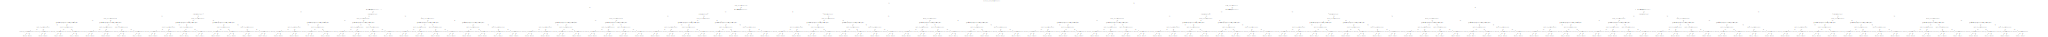

In [12]:
pool = Pool(X_train_processed, y_train, cat_features=cat_features, feature_names=list(X_train_processed.columns))

best_model.plot_tree(
    tree_idx=0,
    pool=pool
)

In [13]:
# Градиентный бустинг из коробки
model_gb = GradientBoostingClassifier(random_state=62025)
grid = {'learning_rate': [0.1, 0.05],
        'max_depth': [4, 6, 8, 12],
        'max_leaf_nodes': [2, 3, 5, 8],
        'n_estimators': [100, 200] }

# Настройка GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=model_gb,
    param_grid=grid,
    cv=3,
    n_jobs=-1
)
# Обучение модели
grid_search_gb.fit(X_train_processed, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=62025),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05],
                         'max_depth': [4, 6, 8, 12],
                         'max_leaf_nodes': [2, 3, 5, 8],
                         'n_estimators': [100, 200]})

In [14]:
# Лучшая модель Градиентный бустинг
best_model_gb = grid_search_gb.best_estimator_
print("\nЛучшие параметры:", grid_search_gb.best_params_)
print("Лучшая AUC (кросс-валидация):", grid_search_gb.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model_gb.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_pred, y_test, average='weighted')
test_roc_auc_score = roc_auc_score(y_test, y_pred)

print("\nТестовая roc_auc_score:", test_roc_auc_score)
print("Тестовый f1_score:", test_f1_score)


Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 4, 'max_leaf_nodes': 5, 'n_estimators': 100}
Лучшая AUC (кросс-валидация): 0.6953948241539484

Тестовая roc_auc_score: 0.712310606060606
Тестовый f1_score: 0.7117864005454658


In [15]:
grid_s = {'learning_rate': [0.01, 0.5],
        'max_depth': [2, 12],
        'max_leaf_nodes': [2,  8],
        'n_estimators': [100, 500] }
search_r = RandomizedSearchCV(model_gb, grid_s, n_iter=16, cv=3,
                                       n_jobs=-1, random_state=62025,
                                       scoring='accuracy')
search_r.fit(X_train_processed, y_train)

RandomizedSearchCV(cv=3,
                   estimator=GradientBoostingClassifier(random_state=62025),
                   n_iter=16, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.5],
                                        'max_depth': [2, 12],
                                        'max_leaf_nodes': [2, 8],
                                        'n_estimators': [100, 500]},
                   random_state=62025, scoring='accuracy')

In [16]:
# Лучшая модель Градиентный бустинг случайный поиск
best_model_gb_search_r = search_r.best_estimator_
print("\nЛучшие параметры:", search_r.best_params_)
print("Лучшая AUC (кросс-валидация):", search_r.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model_gb_search_r.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_pred, y_test)
test_roc_auc_score = roc_auc_score(y_test, y_pred)

print("\nТестовая roc_auc_score:", test_roc_auc_score)
print("Тестовый f1_score:", test_f1_score)


Лучшие параметры: {'n_estimators': 500, 'max_leaf_nodes': 8, 'max_depth': 12, 'learning_rate': 0.01}
Лучшая AUC (кросс-валидация): 0.6844547666445476

Тестовая roc_auc_score: 0.7310606060606062
Тестовый f1_score: 0.7547169811320755


## Логистическая регрессия

In [17]:
# Преобзазуем данные для линейной модели
# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=62025, stratify=y
)

# Проверка баланса классов
print("\nРаспределение классов:")
print(f"Обучающая выборка: {np.unique(y_train, return_counts=True)}")
print(f"Тестовая выборка: {np.unique(y_test, return_counts=True)}")

# Создаем преобразователь признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('bool', 'passthrough', bool_features)
    ],
    remainder='drop'
)

# Применяем преобразования
X_train_l = preprocessor.fit_transform(X_train)
X_test_l = preprocessor.transform(X_test)


logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_train_l, y_train)
search.best_params_


Распределение классов:
Обучающая выборка: (array([0, 1]), array([388, 388], dtype=int64))
Тестовая выборка: (array([0, 1]), array([97, 97], dtype=int64))


{'C': 3.3770629943240693, 'penalty': 'l1'}

In [18]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0, C = 2.195254015709299, penalty = 'l1')

In [19]:
logistic = logistic.fit(X_train_l, y_train)

In [20]:
print(logistic.coef_, logistic.intercept_)

[[-1.39876279e-02 -1.39876279e-02 -1.04257437e-01  1.38290398e-02
  -7.99928346e-03  1.06382688e-01  6.33358361e-04  0.00000000e+00
   1.12977147e-03  1.61836228e-02 -4.04827042e-02  7.25269326e-02
  -1.52361057e-01  0.00000000e+00  1.26606723e-01  1.60269708e-02
  -1.55489956e-01 -3.28758009e-02  1.55962762e-01 -2.58134848e-02
   9.26512775e-02 -1.90063375e-01  3.12467808e-02  6.78492903e-03
  -2.66566151e-01 -4.39385328e-03  4.74789425e-06  3.83899807e-03
   8.28736847e-03  1.22120796e-02  5.56081536e-03  1.13591034e-02
   1.40288282e-02  9.67360982e-03 -4.98133539e-06 -1.78494966e-02
   5.76214829e-02  7.17082991e-02  4.85875909e-02  3.56795890e-02
  -1.64210331e-02  1.54652692e-01  5.38214176e-06 -1.46118714e-02
  -1.68429258e-01  2.41999472e-06  1.18036577e-01  1.31801940e-01
  -1.51016177e-01  1.63176780e-01  3.74594042e-03  3.83659775e-02
  -9.60189483e-02 -2.46963984e-01 -1.06551906e-02  4.07054329e-03
  -2.16054184e-01  1.10817911e-01  1.23749053e-01  1.33358301e-02
   8.96848

In [21]:
# Лучшая модель
best_model_search_l = search.best_estimator_
print("\nЛучшие параметры:", search.best_params_)
print("Лучшая AUC (кросс-валидация):", search.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model_search_l.predict(X_test_l)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_pred, y_test)
test_roc_auc_score = roc_auc_score(y_test, y_pred)

print("\nТестовая roc_auc_score:", test_roc_auc_score)
print("Тестовый f1_score:", test_f1_score)


Лучшие параметры: {'C': 3.3770629943240693, 'penalty': 'l1'}
Лучшая AUC (кросс-валидация): 0.6868403639371381

Тестовая roc_auc_score: 0.6958762886597937
Тестовый f1_score: 0.6878306878306878


## Нейронная сеть

In [22]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda



Распределение классов:
Обучающая выборка: (array([0, 1]), array([388, 388], dtype=int64))
Тестовая выборка: (array([0, 1]), array([97, 97], dtype=int64))

Количество классов: 2
Размерность входных данных: 405
ClassificationNN(
  (layers): Sequential(
    (0): Linear(in_features=405, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, mome

D:\jupiter\conda_inst\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] | Train Loss: 0.7907, Acc: 0.5387 | Val Loss: 0.6665, Acc: 0.5928 | LR: 0.001000
Новая лучшая модель сохранена с точностью: 0.5928
Epoch [2/100] | Train Loss: 0.7502, Acc: 0.5399 | Val Loss: 0.6246, Acc: 0.6701 | LR: 0.001000
Новая лучшая модель сохранена с точностью: 0.6701
Epoch [3/100] | Train Loss: 0.6905, Acc: 0.5889 | Val Loss: 0.6050, Acc: 0.7062 | LR: 0.001000
Новая лучшая модель сохранена с точностью: 0.7062
Epoch [4/100] | Train Loss: 0.6799, Acc: 0.6134 | Val Loss: 0.5751, Acc: 0.6546 | LR: 0.001000
Epoch [5/100] | Train Loss: 0.6430, Acc: 0.6186 | Val Loss: 0.5479, Acc: 0.7113 | LR: 0.001000
Новая лучшая модель сохранена с точностью: 0.7113
Epoch [6/100] | Train Loss: 0.5981, Acc: 0.6830 | Val Loss: 0.5311, Acc: 0.7268 | LR: 0.001000
Новая лучшая модель сохранена с точностью: 0.7268
Epoch [7/100] | Train Loss: 0.6137, Acc: 0.6856 | Val Loss: 0.5416, Acc: 0.6804 | LR: 0.001000
Epoch [8/100] | Train Loss: 0.5853, Acc: 0.6856 | Val Loss: 0.5199, Acc: 0.7010 | LR:

C:\Users\ipd08\AppData\Local\Temp\ipykernel_3376\2296772236.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_classification_model.pth')


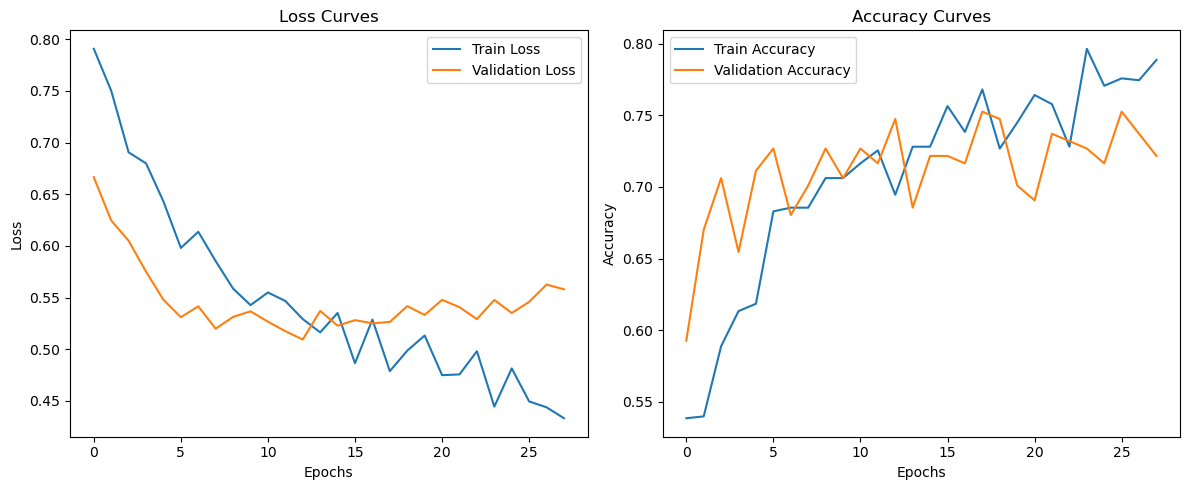

In [25]:

X = df[cat_features + numeric_features + bool_features]

# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=62025, stratify=y
)

# Проверка баланса классов
print("\nРаспределение классов:")
print(f"Обучающая выборка: {np.unique(y_train, return_counts=True)}")
print(f"Тестовая выборка: {np.unique(y_test, return_counts=True)}")

# Прдобработка

# Создаем преобразователь признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('bool', 'passthrough', bool_features)
    ],
    remainder='drop'
)

# Применяем преобразования
X_train_pt = preprocessor.fit_transform(X_train)
X_test_pt = preprocessor.transform(X_test)

# Определяем количество классов
num_classes = len(np.unique(y))
print(f"\nКоличество классов: {num_classes}")

# Преобразование в тензоры PyTorch (ОСТАВЛЯЕМ НА CPU)
X_train_tensor = torch.tensor(X_train_pt.astype(np.float32))
y_train_tensor = torch.tensor(np.array(y_train).astype(np.int64))
X_test_tensor = torch.tensor(X_test_pt.astype(np.float32))
y_test_tensor = torch.tensor(np.array(y_test).astype(np.int64))

# Создание DataLoader (УБРАЛИ pin_memory=True)
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определяем размерность входа
input_dim = X_train_pt.shape[1]
print(f"Размерность входных данных: {input_dim}")

# Сеть

class ClassificationNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.7),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        return self.layers(x)

# Инициализация модели
model_pt = ClassificationNN(input_dim, num_classes).to(device)
print(model_pt)

# Функция потерь и оптимизатор (всегда используем CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Обучение

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        # ПЕРЕМЕЩАЕМ ДАННЫЕ НА УСТРОЙСТВО ВНУТРИ ЦИКЛА
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Всегда используем CrossEntropyLoss
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
        # Расчет точности
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    
    return train_loss / len(loader.dataset), correct / total

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in loader:
            # ПЕРЕМЕЩАЕМ ДАННЫЕ НА УСТРОЙСТВО ВНУТРИ ЦИКЛА
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item() * inputs.size(0)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return val_loss / len(loader.dataset), correct / total, np.array(all_preds), np.array(all_targets)

num_epochs = 100
best_accuracy = 0.0
patience = 10
patience_counter = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Обучение
    train_loss, train_acc = train_epoch(model_pt, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Валидация
    val_loss, val_acc, val_preds, val_targets = validate(model_pt, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Планировщик
    scheduler.step(val_loss)
    
    # Вывод статистики
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | '
          f'LR: {current_lr:.6f}')
    
    # Сохранение лучшей модели
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_pt.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': best_accuracy,
        }, 'best_classification_model.pth')
        print(f"Новая лучшая модель сохранена с точностью: {best_accuracy:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Ранняя остановка на эпохе {epoch+1}')
            break

# Загрузка лучшей модели
checkpoint = torch.load('best_classification_model.pth')
model_pt.load_state_dict(checkpoint['model_state_dict'])
model_pt.eval()

# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('classification_training.png')
plt.show()


Классификационные метрики:
Accuracy: 0.7526
Precision: 0.7543
Recall: 0.7526
F1: 0.7522
Roc_auc: 0.8211


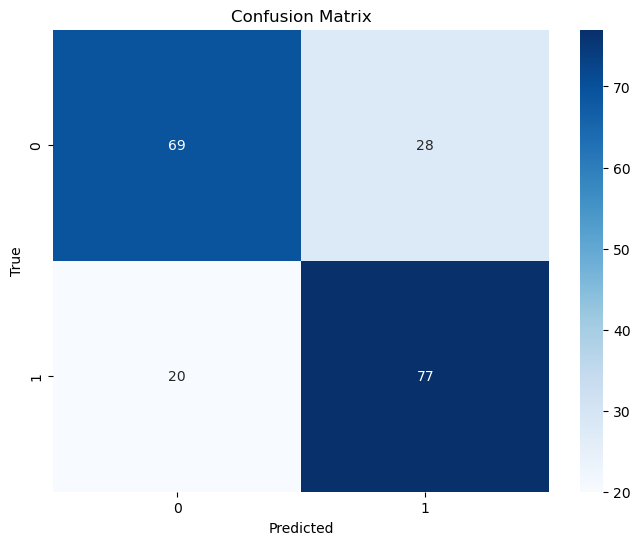

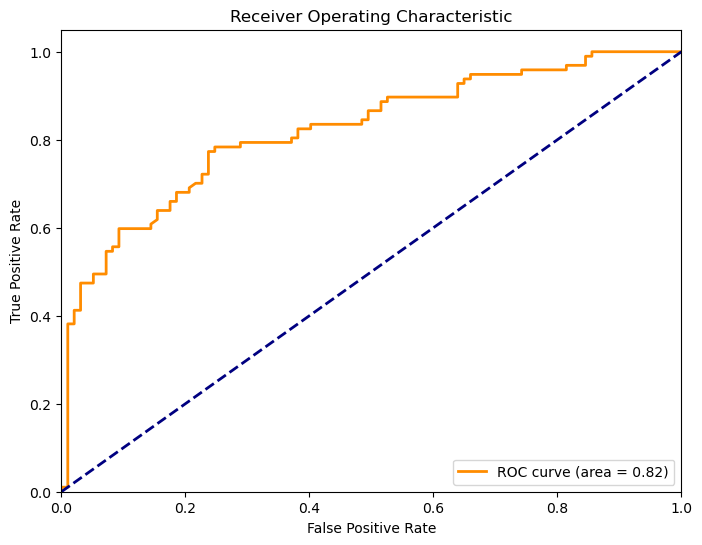


Отчет о классификации:
              precision    recall  f1-score   support

     Class 0       0.78      0.71      0.74        97
     Class 1       0.73      0.79      0.76        97

    accuracy                           0.75       194
   macro avg       0.75      0.75      0.75       194
weighted avg       0.75      0.75      0.75       194



In [26]:
# Оценка на тесте

# Функция для расчета метрик классификации
def calculate_classification_metrics(y_true, y_pred, y_probs=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted')
    }
    
    # ROC-AUC только для бинарной классификации
    if num_classes == 2 and y_probs is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_probs)
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    
    return metrics, cm

# Предсказание на тестовом наборе
all_preds = []
all_probs = []
all_targets = []
model_pt.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        # ПЕРЕМЕЩАЕМ ДАННЫЕ НА УСТРОЙСТВО ВНУТРИ ЦИКЛА
        inputs = inputs.to(device)
        outputs = model_pt(inputs)
        
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_targets.extend(targets.numpy())  # targets остались на CPU

y_pred_pt = np.array(all_preds)
y_true_pt = np.array(all_targets)
y_probs_pt = np.array(all_probs)

# Расчет метрик
metrics, cm = calculate_classification_metrics(
    y_true_pt, y_pred_pt, 
    y_probs_pt[:, 1] if num_classes == 2 else None
)

print("\nКлассификационные метрики:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# Кривая ROC (для бинарной классификации)
if num_classes == 2:
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true_pt, y_probs_pt[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

# Отчет о классификации
from sklearn.metrics import classification_report
print("\nОтчет о классификации:")
print(classification_report(y_true_pt, y_pred_pt, target_names=[f'Class {i}' for i in range(num_classes)]))

# Вывод:
Здесь получились одни из лучших моделей для классификации медианного значения IC50. 

**Лучше всех с задачей справилась нейронная сеть.** При этом стоить отметить качество Логистической регрессии (все неважные, мультиколлинеарные признаки занулились), которая оказалась незначительно хуже остальных моделей. 

Однако, ввиду лучшего качества нейронной сети 0.82 ROC_AUC, отдадим предпочтение данной модели. При обрезании мусорных признаков и правильной агригации существующих, присутствует возможность поввысить качество предсказания модели.